# UNReLo Weather-Forecasting Model
This is a custom model created to forecast weather elements i.e humidity and temperature using weather data collected for over 5 years

Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

Load data from the CSV file

In [2]:
nairobi_weather = pd.read_csv("data/TA00026.csv", index_col='timestamp (UTC)')

# Exploratory Data Analysis

In [3]:
print(nairobi_weather.shape)
nairobi_weather.describe()

(43824, 7)


,precipitation (mm),relativehumidity AVG (-),soilmoisture S001263 AVG (m3/m3),soilmoisture S001391 AVG (m3/m3),temperature AVG (degrees Celsius),temperature MAX (degrees Celsius),temperature MIN (degrees Celsius)
count,43802.000000,43741.000000,5007.000000,22481.000000,43773.000000,43773.000000,43773.000000
mean,0.117269,0.715176,0.195224,0.187951,17.752863,18.421413,17.104834
std,1.266188,0.200471,0.062109,0.048850,4.503781,4.615403,4.427316
min,0.000000,0.081417,0.115000,0.113250,6.575000,7.000000,6.000000
25%,0.000000,0.580833,0.133458,0.145000,14.366667,14.800000,13.900000
50%,0.000000,0.742167,0.182364,0.189000,17.100000,17.800000,16.400000
75%,0.000000,0.883500,0.258000,0.231917,21.166667,22.000000,20.400000
max,112.300000,1.000000,0.334500,0.340000,31.008333,32.000000,30.500000


In [4]:
nairobi_weather.head()

,precipitation (mm),relativehumidity AVG (-),soilmoisture S001263 AVG (m3/m3),soilmoisture S001391 AVG (m3/m3),temperature AVG (degrees Celsius),temperature MAX (degrees Celsius),temperature MIN (degrees Celsius)
timestamp (UTC),,,,,,,
2018-01-01 00:00,0.0,0.728333,NaN,NaN,13.166667,14.3,12.2
2018-01-01 01:00,0.0,0.785000,NaN,NaN,11.925000,12.2,11.6
2018-01-01 02:00,0.0,0.819167,NaN,NaN,11.041667,11.5,10.5
2018-01-01 03:00,0.0,0.853333,NaN,NaN,10.333333,10.5,10.2
2018-01-01 04:00,0.4,0.805833,NaN,NaN,12.633333,15.8,10.3


In [5]:
weather=nairobi_weather[['temperature AVG (degrees Celsius)','relativehumidity AVG (-)']]
weather.columns=['avg_temp','avg_humidity']
weather.head()

,avg_temp,avg_humidity
timestamp (UTC),,
2018-01-01 00:00,13.166667,0.728333
2018-01-01 01:00,11.925000,0.785000
2018-01-01 02:00,11.041667,0.819167
2018-01-01 03:00,10.333333,0.853333
2018-01-01 04:00,12.633333,0.805833


Check for null/missing values

In [6]:
weather.apply(pd.isnull).sum()/nairobi_weather.shape[0]*100

avg_temp        0.116375
avg_humidity    0.189394
dtype: float64

Deal with missing values

In [7]:
#fill with previous value
weather=weather.fillna(method='ffill')
weather.apply(pd.isnull).sum()/weather.shape[0]*100

avg_temp        0.0
avg_humidity    0.0
dtype: float64

Make sure we have correct data types

In [8]:
#convert index type to datetime
weather.index=pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp (UTC)', length=43824, freq=None)

Visualize the data 

<Axes: xlabel='timestamp (UTC)'>

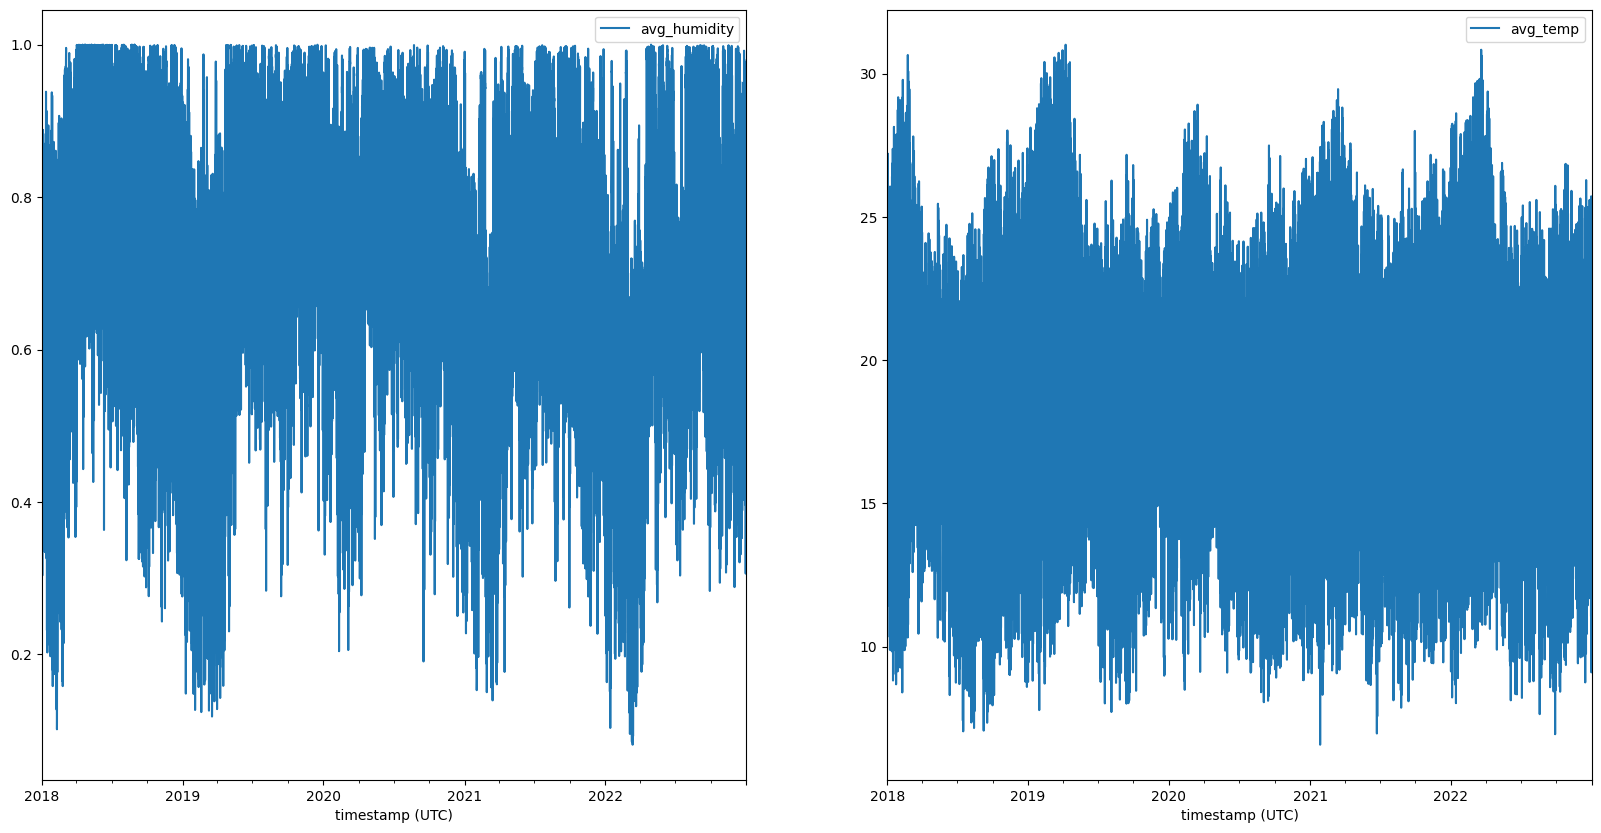

In [9]:
# weather[['avg_humidity']].plot()
# weather[['avg_temp']].plot()
fig, ax = plt.subplots(1,2,figsize=(20,10))
weather[['avg_humidity']].plot(ax=ax[0])
weather[['avg_temp']].plot(ax=ax[1])


# Create the model

In [10]:
weather['target_temp']=weather['avg_temp'].shift(-1)
weather['target_humidity']=weather['avg_humidity'].shift(-1)
weather

,avg_temp,avg_humidity,target_temp,target_humidity
timestamp (UTC),,,,
2018-01-01 00:00:00,13.166667,0.728333,11.925000,0.785000
2018-01-01 01:00:00,11.925000,0.785000,11.041667,0.819167
2018-01-01 02:00:00,11.041667,0.819167,10.333333,0.853333
2018-01-01 03:00:00,10.333333,0.853333,12.633333,0.805833
2018-01-01 04:00:00,12.633333,0.805833,17.666667,0.632500
...,...,...,...,...
2022-12-31 19:00:00,17.983333,0.537333,18.133333,0.477000
2022-12-31 20:00:00,18.133333,0.477000,17.575000,0.494167
2022-12-31 21:00:00,17.575000,0.494167,17.250000,0.511917


In [11]:
#drop last row since it has no target
weather=weather.dropna()
weather

,avg_temp,avg_humidity,target_temp,target_humidity
timestamp (UTC),,,,
2018-01-01 00:00:00,13.166667,0.728333,11.925000,0.785000
2018-01-01 01:00:00,11.925000,0.785000,11.041667,0.819167
2018-01-01 02:00:00,11.041667,0.819167,10.333333,0.853333
2018-01-01 03:00:00,10.333333,0.853333,12.633333,0.805833
2018-01-01 04:00:00,12.633333,0.805833,17.666667,0.632500
...,...,...,...,...
2022-12-31 18:00:00,18.641667,0.521583,17.983333,0.537333
2022-12-31 19:00:00,17.983333,0.537333,18.133333,0.477000
2022-12-31 20:00:00,18.133333,0.477000,17.575000,0.494167


We will use ridge regression since it minimizes overfitting

In [12]:
reg = Ridge(alpha=.1)
# alpha is a hyperparameter that controls the amount of regularization applied to the model

Split training and testing data

In [13]:
predictors = weather[['avg_temp','avg_humidity']]
target=weather[['target_temp','target_humidity']]

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35058, 2), (8765, 2), (35058, 2), (8765, 2))

In [14]:
reg.fit(X_train,y_train)
predictions=reg.predict(X_train)
predictions

array([[12.65396671,  0.87612499],
       [15.20911187,  0.86489331],
       [16.46203021,  0.81631635],
       ...,
       [15.96187726,  0.92448525],
       [19.34000815,  0.60814901],
       [14.62949952,  0.95498658]])

Check the mean absolute error

In [15]:
print("Mean absolute error on testing data: {:.4f}%".format(mean_absolute_error(y_train,predictions)))

Mean absolute error on testing data: 0.5781%


In [16]:
combined=pd.concat([y_train,pd.DataFrame(predictions,index=y_train.index,columns=['predicted_temp','predicted_humidity'],)],axis=1)
combined.sort_index(inplace=True)
combined

,target_temp,target_humidity,predicted_temp,predicted_humidity
timestamp (UTC),,,,
2018-01-01 02:00:00,10.333333,0.853333,11.098141,0.837544
2018-01-01 03:00:00,12.633333,0.805833,10.445922,0.870590
2018-01-01 05:00:00,20.941667,0.517500,17.484967,0.643864
2018-01-01 06:00:00,23.466667,0.425833,20.593212,0.528389
2018-01-01 08:00:00,25.283333,0.346667,23.938361,0.365698
...,...,...,...,...
2022-12-31 18:00:00,17.983333,0.537333,18.244918,0.542904
2022-12-31 19:00:00,18.133333,0.477000,17.604214,0.559719
2022-12-31 20:00:00,17.575000,0.494167,17.627795,0.506616


<Axes: xlabel='timestamp (UTC)'>

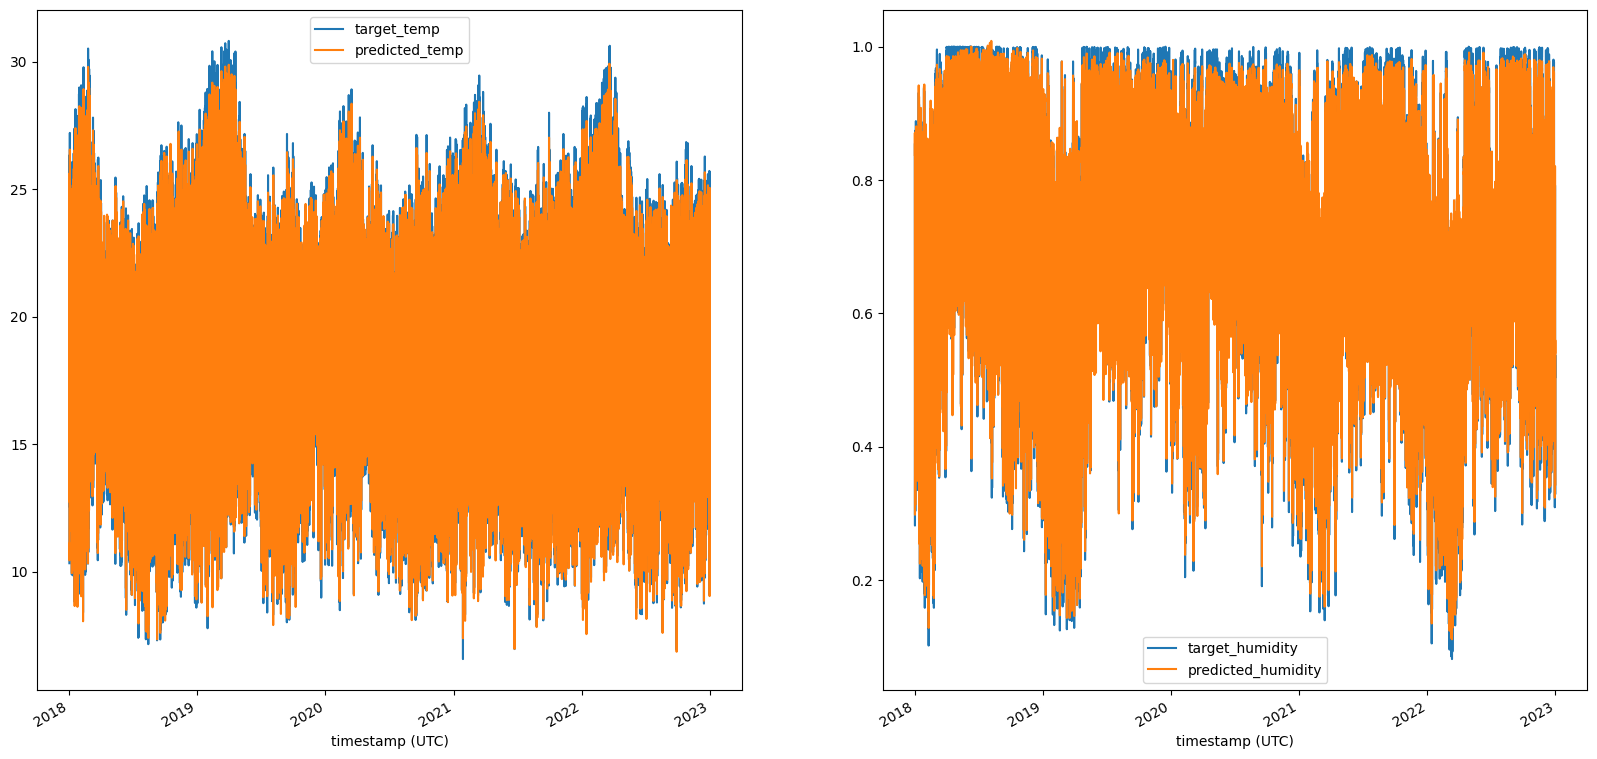

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
combined[['target_temp','predicted_temp']].plot(ax=ax[0])
combined[['target_humidity','predicted_humidity']].plot(ax=ax[1])
# combined[['target_temp','predicted_temp']].plot()
# combined[['target_humidity','predicted_humidity']].plot()

In [18]:
weather.corr()[['target_temp','target_humidity']]

,target_temp,target_humidity
avg_temp,0.945057,-0.837021
avg_humidity,-0.766318,0.959529
target_temp,1.000000,-0.840108
target_humidity,-0.840108,1.000000


In [19]:
def predict(predictors, weather, reg):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)
    reg.fit(X_train,y_train)
    predictions=reg.predict(X_train)
    error=mean_absolute_error(y_train,predictions)
    combined=pd.concat([y_train,pd.DataFrame(predictions,index=y_train.index,columns=['predicted_temp','predicted_humidity'],)],axis=1)
    combined.sort_index(inplace=True)
    return error,combined


# Optimizing model

In [20]:
weather['daily_avg_temp']=weather['avg_temp'].rolling(24).mean()
weather['daily_avg_humidity']=weather['avg_humidity'].rolling(24).mean()
weather

,avg_temp,avg_humidity,target_temp,target_humidity,daily_avg_temp,daily_avg_humidity
timestamp (UTC),,,,,,
2018-01-01 00:00:00,13.166667,0.728333,11.925000,0.785000,NaN,NaN
2018-01-01 01:00:00,11.925000,0.785000,11.041667,0.819167,NaN,NaN
2018-01-01 02:00:00,11.041667,0.819167,10.333333,0.853333,NaN,NaN
2018-01-01 03:00:00,10.333333,0.853333,12.633333,0.805833,NaN,NaN
2018-01-01 04:00:00,12.633333,0.805833,17.666667,0.632500,NaN,NaN
...,...,...,...,...,...,...
2022-12-31 18:00:00,18.641667,0.521583,17.983333,0.537333,17.590278,0.572910
2022-12-31 19:00:00,17.983333,0.537333,18.133333,0.477000,17.630903,0.570618
2022-12-31 20:00:00,18.133333,0.477000,17.575000,0.494167,17.754861,0.564000


Get daily mean from rolling mean

In [21]:
weather['daily_avg_temp']=weather['daily_avg_temp'].groupby(weather.index.date).transform('mean')
weather['daily_avg_humidity']=weather['daily_avg_humidity'].groupby(weather.index.date).transform('mean')
weather


,avg_temp,avg_humidity,target_temp,target_humidity,daily_avg_temp,daily_avg_humidity
timestamp (UTC),,,,,,
2018-01-01 00:00:00,13.166667,0.728333,11.925000,0.785000,19.372569,0.520174
2018-01-01 01:00:00,11.925000,0.785000,11.041667,0.819167,19.372569,0.520174
2018-01-01 02:00:00,11.041667,0.819167,10.333333,0.853333,19.372569,0.520174
2018-01-01 03:00:00,10.333333,0.853333,12.633333,0.805833,19.372569,0.520174
2018-01-01 04:00:00,12.633333,0.805833,17.666667,0.632500,19.372569,0.520174
...,...,...,...,...,...,...
2022-12-31 18:00:00,18.641667,0.521583,17.983333,0.537333,17.718705,0.559250
2022-12-31 19:00:00,17.983333,0.537333,18.133333,0.477000,17.718705,0.559250
2022-12-31 20:00:00,18.133333,0.477000,17.575000,0.494167,17.718705,0.559250


In [22]:
predictors=weather[['avg_temp','avg_humidity','daily_avg_temp','daily_avg_humidity']]
error,combined=predict(predictors, weather, reg)
print("Mean absolute error on testing data: {:.4f}%".format(error))
combined

Mean absolute error on testing data: 0.5560%


,target_temp,target_humidity,predicted_temp,predicted_humidity
timestamp (UTC),,,,
2018-01-01 02:00:00,10.333333,0.853333,11.675405,0.813100
2018-01-01 03:00:00,12.633333,0.805833,11.097572,0.842836
2018-01-01 05:00:00,20.941667,0.517500,18.182932,0.612584
2018-01-01 06:00:00,23.466667,0.425833,21.211242,0.500191
2018-01-01 08:00:00,25.283333,0.346667,24.219285,0.352420
...,...,...,...,...
2022-12-31 18:00:00,17.983333,0.537333,18.502509,0.528026
2022-12-31 19:00:00,18.133333,0.477000,17.832614,0.546317
2022-12-31 20:00:00,17.575000,0.494167,17.514229,0.509012


In [23]:
weather.corr()[['target_temp','target_humidity']]

,target_temp,target_humidity
avg_temp,0.945057,-0.837021
avg_humidity,-0.766318,0.959529
target_temp,1.000000,-0.840108
target_humidity,-0.840108,1.000000
daily_avg_temp,0.336638,-0.496055
daily_avg_humidity,-0.274522,0.635169


# Export the model

In [24]:
joblib.dump(reg, 'reg.pkl')

['reg.pkl']

In [25]:
model = Sequential([
    Dense(2, input_shape=(4,), activation='linear')
])
model.set_weights([reg.coef_.T, reg.intercept_])

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Lrnovo\AppData\Local\Temp\tmp2xo_l_ht\assets


In [26]:
sample = pd.read_csv("sample/sample_1.csv", index_col='timestamp (UTC)')
sample.fillna(0, inplace=True)

sample

,avg_temp,avg_humidity,daily_avg_temp,daily_avg_humidity
timestamp (UTC),,,,
1/1/2023 0:00,0.0,0.0,0.0,0.0
1/1/2023 1:00,0.0,0.0,0.0,0.0
1/1/2023 2:00,0.0,0.0,0.0,0.0
1/1/2023 3:00,0.0,0.0,0.0,0.0
1/1/2023 4:00,0.0,0.0,0.0,0.0
...,...,...,...,...
6/30/2023 19:00,0.0,0.0,0.0,0.0
6/30/2023 20:00,0.0,0.0,0.0,0.0
6/30/2023 21:00,0.0,0.0,0.0,0.0


In [27]:
predictions = reg.predict(sample)

predictions

array([[0.0454484 , 0.02791817],
       [0.0454484 , 0.02791817],
       [0.0454484 , 0.02791817],
       ...,
       [0.0454484 , 0.02791817],
       [0.0454484 , 0.02791817],
       [0.0454484 , 0.02791817]])